## Going11 : OCR 기술의 개요

### 11-1 들어가며

이미지 속의 문자를 읽는 `OCR`은 크게 문자의 영역을 검출하는 `Text detection`과 검출된 영역의 문자를 인식하는 `Text recognition`으로 구분할 수 있다. 

`Text detection`은 단순히 Object detection 기법 뿐만 아니라 Segmentation 기법도 동원되고, 문자가 가지는 독특한 특성까지 고려한 형태로 지속적으로 발전해왔다.

`Text recognition`은 검출된 영역의 문자가 무엇인지 인식해내는 과정이다. Text detection을 통해 검출된 문자 영역 속에는 MNIST 데이터처럼 문자 단위로 잘 분리된 텍스트 이미지만 담겨 있는 것이 아니다. 이를 위해서 OCR 분야에서 사용하는 독특한 모델 구조에 대해서도 다루게 될 것이다.


Classification, Detection, Segmentation 등의 기법을 결합해 OCR이라는 실용적인 애플리케이션을 완성하는 과정을 살펴보도록 한다.


### 실습목표

- Deep learning 기반의 OCR을 이해합니다.
- Text를 Detection하기 위한 딥러닝 기법을 배웁니다.
- Text를 Recognize하기 위한 딥러닝 기법을 배웁니다.

### 11-2 Before Deep Learning

OCR(Optical Character Recognition)은 자동차 번호판 자동인식, 신용카드 광학 인식 등 이미 우리 생활 속에 OCR 기술이 자연스럽게 녹아들어 온 사례를 어렵지 않게 찾아낼 수 있다.

OCR의 역사는 1928년 오스트리아의 Gustav Tauschek가 포토 센서를 활용한 패턴 매칭을 통해 제작한 "Reading Machine"을 제작했고 1931년 이스라엘의 Emanuel Goldberg가 "Statistical machine"의 특허를 내었는데, 이들이 최초의 OCR 장치로 여겨지고 있다.

OCR에 활용되기 전에는 어떤 방식으로 이미지 속 문자를 찾아냈는지 보게된다. <br/>
https://arxiv.org/pdf/1811.06193.pdf

위 논문을 보게되면 브라우저에서 동작하는 OCR을 이용해 웹에서 유저의 행동을 관찰하는 방법을 제안한다. 온라인 마케팅, 광고 등에도 OCR 기술을 활용할 수 있다는 내용이다. 이 논문에서 제안하는 솔루션 구성도이다.

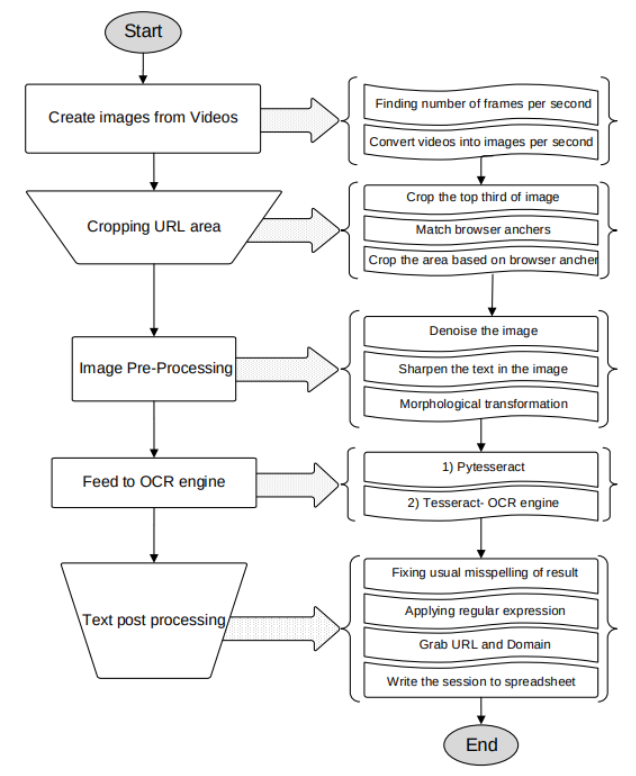

위 그림에서 OCR 엔진으로 Tesseract OCR을 사용하려고 하는 것을 확인할 수 있다. Tesseract OCR은 1985년 휴렛 패커드 사에서 개발이 시작되어 2005년에는 오픈소스로 출시되었고, 2006년부터는 구글의 후원을 받는 오픈소스 OCR 엔진이다. (`최근에는 Tesseract OCR에도 LSTM을 적용`하는 등 딥러닝 베이스 아키텍처로 발전하고있다.)


위 그림은 크게 5단계로 나뉘는데 위 `3단계는 입력 이미지 추출과 전처리`, `4번째 단계는 OCR 처리`, `마지막 5번째 단계는 OCR의 출력 텍스트의 후처리`로 구성된다.

여기서 Tesseract OCR을 통한 4단계의 과정을 아래 그림으로 정리했다.


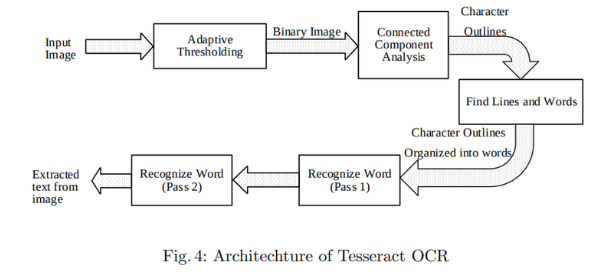

1. 먼저 `Adaptive Thresholding` 단계에서 입력 영상의 이진화를 통해 흑백으로 변환한다.  


2. 이후 `Connected Component Analysis` 단계에서 문자 영역을 검출한 후 `Find Lines and Words`에서 라인 또는 단어 단위를 추출한다.  


3. 이후 `Recognize Word` 단계에서 단어(Word) 단위 이미지를 Text로 변환하기 위해 문자를 하나씩 인식하고 다시 결합하는 과정을 거친다.  



딥러닝 기반의 OCR도 위처럼 복잡할 수 있지만 기본적인 기능을 하기 위해서는 필요한 단계가 많다. 딥러닝의 적용을 통해 원하는 단위로 문자를 검출해내고, 이를 한번에 인식하도록 아키텍처를 단순화하여 빠른 인식을 이뤄낼 수 있다고 한다. 요즘에는 검출과 인식을 동시에 해내는 End-to-End OCR 모델도 연구되고 있다고한다.

## 11-3 Text detection

이미지에서 텍스트의 위치를 찾는 Text Detection 방법에 대해서 생각해본다.


기본적으로 Object Detection이나 Segmentation을 위한 기법들을 떠올릴 수 있지만 이미지 속에서 물체를 찾아낼 때 문자는 조금 다른 특성을 가지고 있다. 문자는 몇 개가 모여서 단어 혹은 문장을 이루고 있기 때문에 이미지 내에서 문자를 검출해낼 땐 `검출하기 위한 최소 단위`를 정해야 한다. 

예를 들어서 이미지 속에서 문장 단위로 위치를 찾겠다 또는 단어나 글자 단위로 위치를 찾겠다고 정할 수 있다.

문장 또는 단어 단위로 찾아낼 경우, 엄청나게 긴 단어나 문장과 함께 짧은 길이도 찾아낼 수 있도록 해야하는 단점이 있다.

반면 글자 단위로 인식하면 되지 않느냐는 생각을 할 수 있지만 이는 글자를 놓치지 않고 찾아내는 데에는 좋을 수 있지만, 글자를 다시 맥락에 맞게 묶어주는 과정을 거쳐야한다는 단점이 있다.


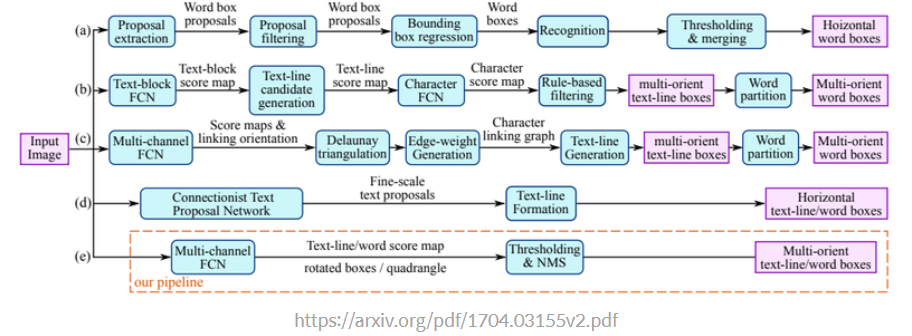

https://arxiv.org/pdf/1704.03155v2.pdf <br/>

위 그림은 2017년에 발표된 `EAST: An Efficient and Accurate Scene Text Detector`라는 논문에서 소개된 다양한 Text detection 기법을 정리한 것이다.


2017년 당시에는 Text의 바운딩 박스를 구하는 방식이 주류를 이루었다. 위 그림을 보면 가로 방향(Horizontal)으로만 텍스트 박스를 구하는 방식이나 기울어지거나 세로 방향 등의 여러 방향(Multi-oriented)의 텍스트 박스를 구하는 방식이 다양하게 소개되고 있다. 


해당 논문이 제시하는 (e)의 경우 전체 파이프라인의 길이가 짧고 간결해서 빠르면서도 정확한 Text detection 성능을 보인다고 소개하고 있다. 


위 그림을 보면 단어 단위의 탐지와 글자 단위의 탐지가 모두 활용되고 있다.

`단어 단위의 탐지`는 앞서 배운 Object detection의 Regression 기반의 Detection 방법이다. Anchor를 정의하고 단어의 유무와 Bounding box의 크기를 추정해서 단어를 찾아낸다.

`글자 단위의 방식`은 Bounding box regression을 사용하는 대신 글자 영역을 Segmentation하는 방법으로 접근한다. 두 가지 방법을 모두 활용한 방법이 있다. 대표적인 것을 살펴보자.


### 1. Regression

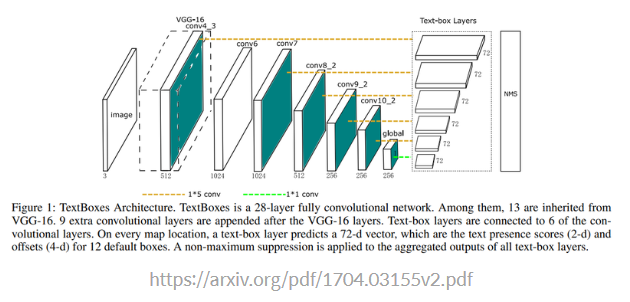

`TextBoxes`는 2017년 AAAI에 공개된 논문이다. 이미지 내에서 문자를 찾아내려는 방법에 다양한 기법들이 활용된다.

TextBoxes 이전에는 글자 단위로 인식하고 결합하는 방식을 취했다면 위 논문에서는 딥러닝 기반의 Detection을 이용해서 단어 단위로 인식하게 된다. 네트워크의 기본 구조는 `SSD(single shot multibox detector)`를 활용했다. 이를 통해 빠르게 문자 영역을 탐지해 낼 수 있었다고 한다.

일반적인 단어들은 가로로 길기 때문에 `Aspect ratio(종횡비)가 크다`. 이에 따라서 몇 가지 변형을 주게 되는데 기존의 SSD에서는 Regression을 위한 Convolution layer에서 3x3 크기의 kernel을 갖는다.

하지만 여기선 긴 단어의 Feature를 활용하기 위해 `1x5로 convolution filter를 정의해서 사용`한다. `Anchor box의 aspect ratio를 1,2,3,5,7로 만들고` 이에 `vertical offset을 적용`해서 세로 방향으로 촘촘한 단어의 배열에 대응하도록 했다.

```
💠 종횡비(Aspect ratio)
종횡비는 가로와 세로 길이의 비를 의미하며, 가로세로비, 영상비, 화면비 등으로 부르기도 합니다. 일반적으로 16:9와 같이 '가로:세로'의 형태로 표현합니다. 그러나 논문에서는 가로와 세로의 비를 계산하여 하나의 숫자로 표현하고 있습니다.
```

```
💠💠 offset
일반적인 의미의 Offset이란 특정한 값에서 차이가 나는 값 또는 차이를 의미합니다. 주의할 점은 offset과 오차가 다르다는 것입니다. offset은 차이가 목적에 의해 만들어진 것과 상황에 따라 자연스럽게 발생된 것을 모두 포함하기 때문입니다.
```

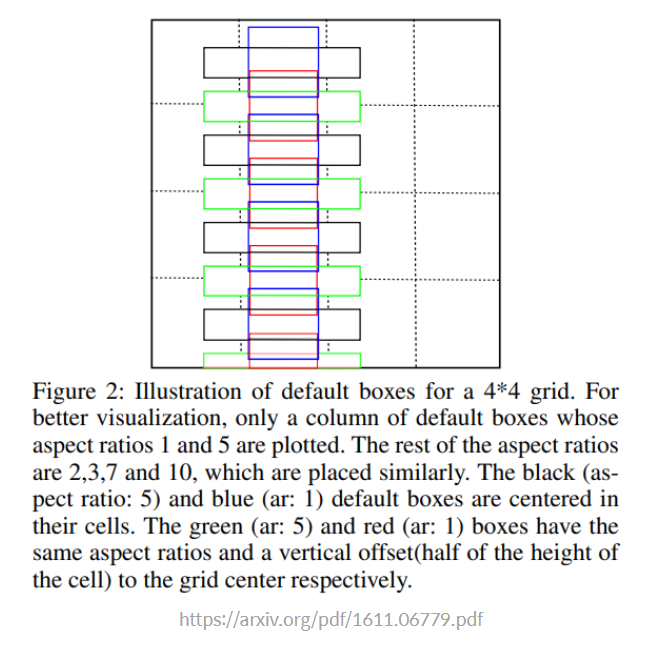


### 2. Segmentation

https://arxiv.org/pdf/1801.01315.pdf

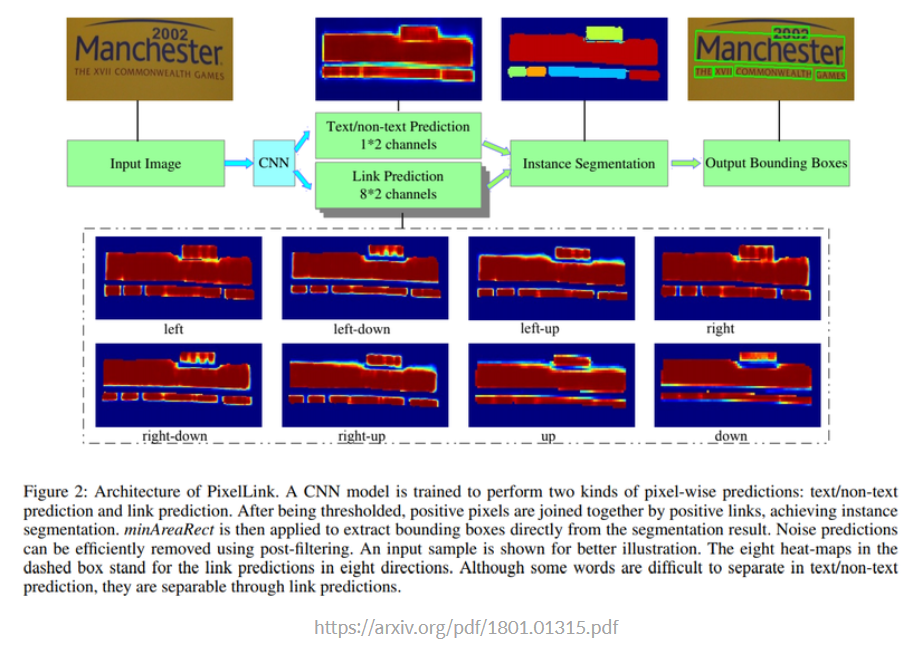

저번에 Sementic segmentation을 이미지 내 영역을 class로 분리해내는 방법을 배웠다. 이 방법을 문자의 영역을 찾기 위해서 적용하게되면 배경과 글자인 영역으로 분리할 수 있다. 하지만 문자들이 촘촘하게 연결되어있기 때문에 글자 영역으로 찾아내고 이를 분리해내는 작업이나 연결하는 작업을 더해서 최소단위로 만들어줘야하는 번거로움이 있다.


PixelLink는 Text 영역을 찾아내는 segmentation과 함께, 글자가 어느 방향으로 연결되는지를 같이 학습하여 Text 영역 간의 분리 및 연결을 할 수 있는 정보를 추가적으로 활용하고 있다고 한다.

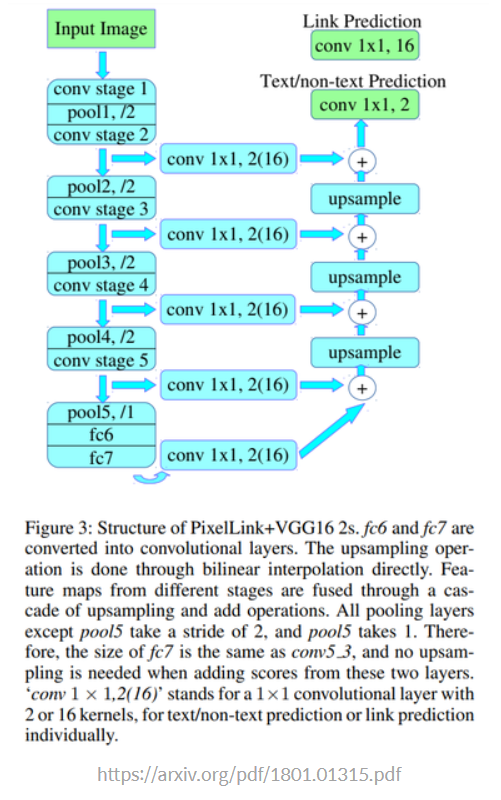

PixelLink의 전체적인 구조는 U-Net과 유사하지만 output으로 9가지의 정보를 얻게된다.

위 그림의 녹색 부분이 input과 output을 의미하는데 output 중에 하나는 `Text/non-text Prediction을 위한 class segmentation map`으로 해당 영역이 Text인지 non-Text인지 예측값을 의미하는 2개 커널을 가지게 된다. 나머지 8가지는 글자의 Pixel을 중심으로 인접한 8개의 Pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 `Link Prediction map`이다.

위 그림을 보면  conv 1X1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어, 인접 pixel간 연결 구조가 지속적으로 유지되도록 하는 모델 구조임을 알 수 있다. 

이를 통해서 인접한 pixel이 중심 pixel과 단어 단위로 연결된 pixel인지, 아니면 분리된 pixel인지 알 수 있으므로, 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해진다.


### 3. 최근의 방법들

#### 3-1 CRAFT

https://arxiv.org/abs/1904.01941

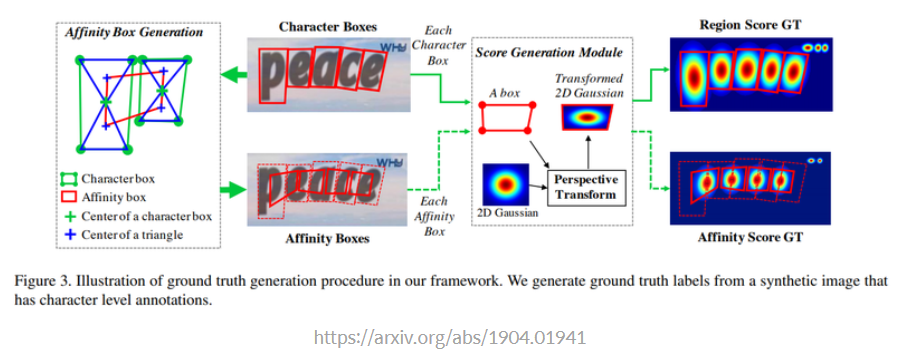

CRAFT는 문자(Character) 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 Segmentation 기반으로 구현한 방법이다. 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습한다.

문자 단위 라벨을 가진 데이터셋이 많지 않기 때문에, 단어 단위의 정보만 있는 데이터셋에 대해 단어의 영역에 Inference를 한 후, 얻어진 문자 단위의 위치를 다시 학습에 활용하는 Weakly supervised learning을 활용했다.


#### 3-2 Pyramid Mask Text Detector

https://arxiv.org/pdf/1903.11800.pdf

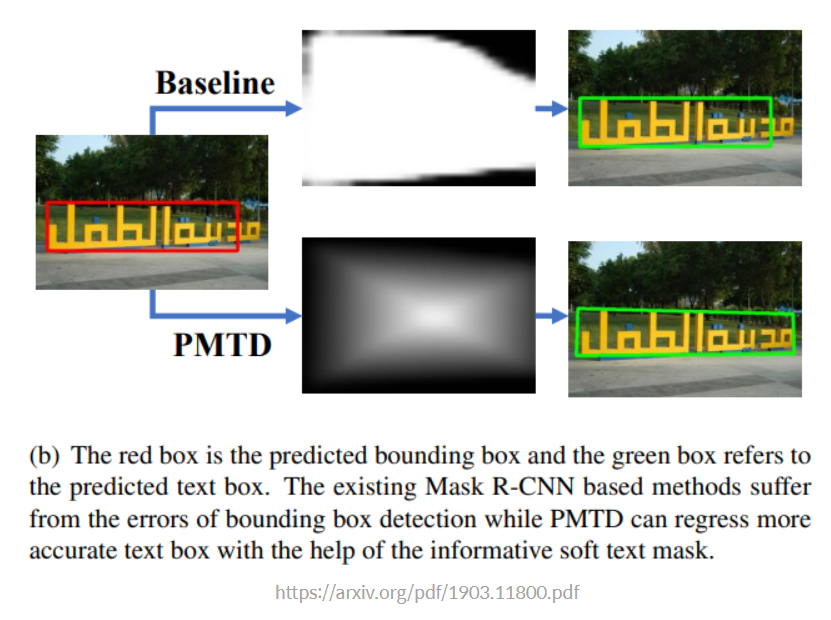

PMTD(Pyramid Mask Text Detector)는 Mask-RCNN의 구조를 활용하여 먼저 Text영역을 Region proposal network로 찾아낸다. 그다음 Box head에서 더 정확하게 regression 및 classification을 하고 Mask head에서 Instance의 Segmentation을 하는 과정을 거친다.

PMTD는 Mask 정보가 부정확한 경우를 반영하기 위해서 Soft-segmentation을 활용한다. 이전의 Mask-RCNN의 경우, 단어 영역이 Box head에 의해 빨간색으로 잡히면 위의 이미지의 baseline처럼 boundary를 모두 Text 영역으로 잡지만, PMTD는 단어의 사각형 배치 특성을 반영하여 피라미드 형태의 Score map을 활용한다. 따라서 Pyramid 형상의 Mask를 갖게 되어 Pyramid Mask Text detector라는 이름을 붙혔다.

## 11-4 Text recognition

### 1. Unsegmented Data

글자 이미지들은 문자의 순서대로 정보를 가지고 있다. 하지만 이와 다르게 분리에 드는 비용이 많이 들거나 어려워 Segmentation이 되어있지 않은 데이터를 `Unsegmented data`라고 한다. OCR 뿐만 아니라 다른 분야에서도 이런 데이터를 볼 수 있다. 

예를 들어, 아래와 같이 annotation이 제대로 되지 않은 음성 데이터도 Unsegmented data의 한 종류이다. Waveform 파일에 대한 라벨이 "the sound of"라고 달려있다면, 해당 waveform 파일에서 어디까지가 각각 "the", "sound", "of"인지 경계가 명확하게 분할되어 있지 않은 경우를 생각할 수 있다. 

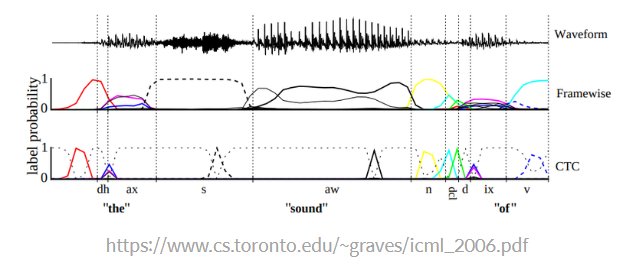


### 2. CNN과 RNN의 만남 CRNN

https://arxiv.org/pdf/1507.05717.pdf

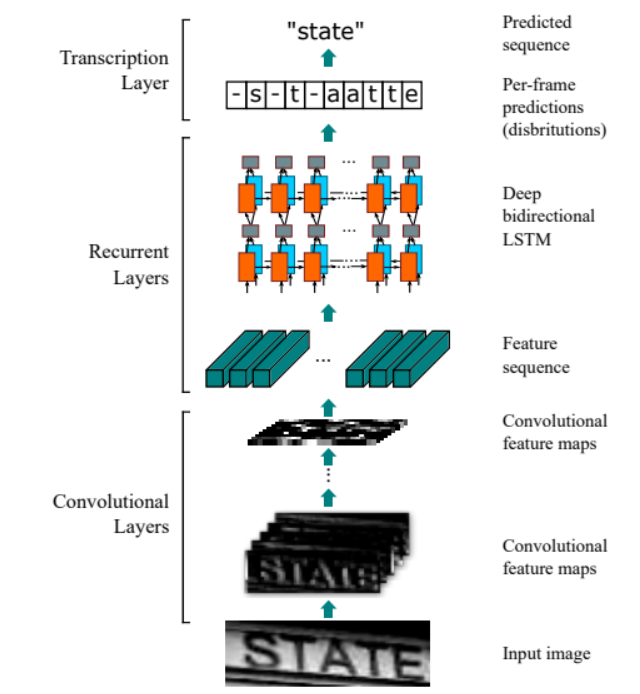

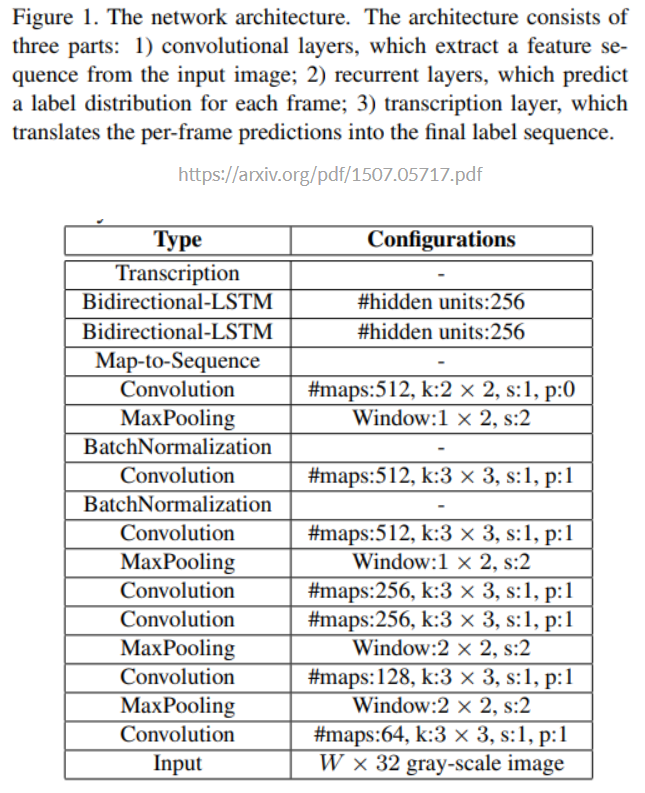

Unsegmented Data들이 가진 주요한 특징 중 하나는 segment되어 있지 않은 하위 데이터들끼리 시퀀스(sequence)를 이루고 있다는 점이다.

그래서 생각해 낸 방법 중 하나가 `CNN(Convolutional neural network)과 RNN(Recurrent neural network)을 같이 쓰는 방법`이다. 이런 모델을 `CRNN`이라고 한다. 

문자 이미지에서 정보를 추출하기 위해서는 `Feature Extractor`가 필요하다. Feature Extractor로 사용되는 CNN 기반의 VGG 또는 ResNet과 같은 네트워크로부터 문자의 정보를 가진 Feature를 얻어낼 수 있다. 추출된 Feature를 Map-To-Sequence를 통해 Sequence 형태의 feature로 변환하고 다양한 길이의 Input을 처리할 수 있는 RNN으로 넣는다.


RNN이 Feature로부터 문자를 인식하기 위해서 문자 영역처럼 넓은 정보가 필요하기 때문에 `LSTM`으로 구성한다. 앞 정보뿐만 아니라 뒤의 정보가 필요하기 때문에 이를 Bidirectional로 구성해서 `Bidirectional LSTM을 사용`했다. Bidirectional LSTM을 사용해 step마다 나오는 결과는 `Transcription Layer에서 문자로 변환`된다.


### 3. CTC

CRNN에서는 Step마다 Fully Connected Layer의 logit을 Softmax 함수에 넣어줌으로써 어떤 문자일 확률이 높은지 알 수 있다. 

하지만 이 결과 그대로를 문자로 변환하면 기대한 것과 다른 결과가 나오게 된다. 왜냐하면 모델의 Output은 24개의 글자로 이루어진 Sequence이지만, 실제 결과는 이와 다르기 때문이다. 

예를 들어서 "HELLO"라는 이미지가 들어오면 이것의 Output이 "HHHEEELLLOOOOO..."와 같이 24자의 sequence를 보게 된다.

이 24자의 Sequence를 실제 인식 결과로 바꾸기 위해서 어떤 방법을 써야할까

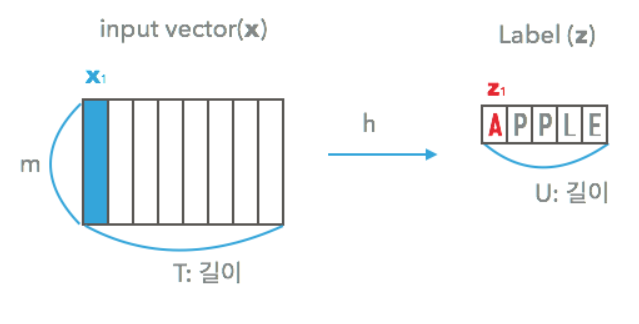

CRNN에서는 Unsegmented Data를 위해서 `CTC(Connectionist Temporal Classification`을 활용하게 된다. CTC는 Unsegmented data와 같이 Input과 Output이 서로 다른 Length의 Sequence를 가질 때, 이를 Align 없이 활용하는 방법이다. 

논문에서 언급하는 CTC의 핵심인 모델의 Output에서 Label sequence의 확률을 구할 수 있는 방법에 대해서 알아본다.

위에서 본 "HHHEEELLLOOOOO..."를 "HELLO"로 만들기 위해서는 중복되는 단어인 "HHHH..."나 "EEE...", "LLL..."들을 "H", "E", "L" 등으로 바꿔볼 수 있다. 그러면 "HELO"가 될 것이다. 그렇다면 "L"이 두 번 중복되는 경우에는 어떻게 구분할 수 있을까?

앞서 봤듯이 Label Encode에서 이렇게 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어준다.

아래 그림은 Blank token을 '-'로 대신하여 Output을 만드는 Decoder를 의미한다. Decode 후에 중복을 제거하고, 인식할 문자가 아닌 값을 지워주면 "HELLO"라는 결과를 얻을 수 있다.

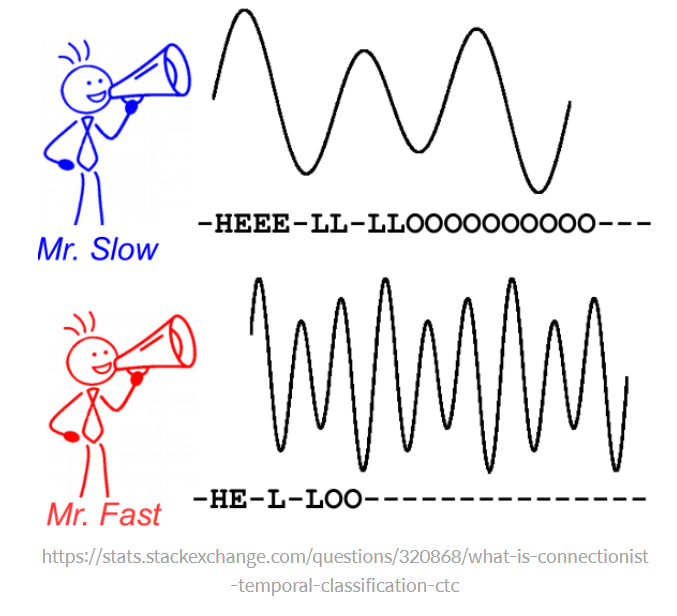

### 4. TPS

책이 아닌 거리의 글자를 읽을 때, OCR이 어려워지는 이유는 불규칙한 방향이나 휘어진 진행 방향 때문이다. 

논문 `Robust Scene Text Recognition With Automatic Rectification`에서는 Thin Plate Spline (TPS) Transformation을 적용해서 입력 이미지르 단어 영역에 맞게 변형시켜서 인식이 잘되도록 해준다. 

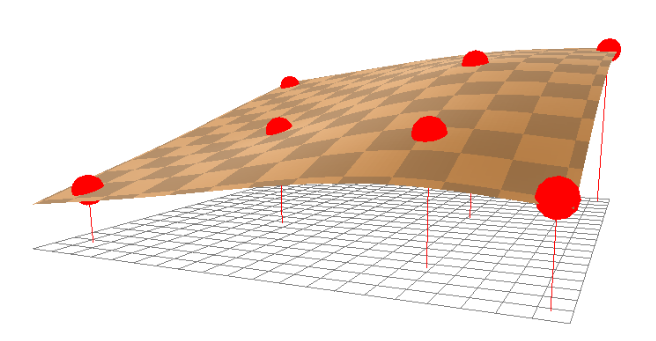

`Thin plate spline`은 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때, 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정해낸다고 한다. 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있다. 

논문에서는 Control point 20개를 미리 정의하고 `Spatial Transformer Network`를 통해서 Control point가 얼마나 움직여야 하는지 예측하는 네트워크를 아래 그림과 같이 Recognition model 앞단에 붙여 입력 이미지를 정방향으로 맞춰준다. TPS 연산은 미분 가능한 연산이기 때문에 이 모듈을 Recognition model 앞단에 붙여서 학습이 바로 가능하게 된다. 

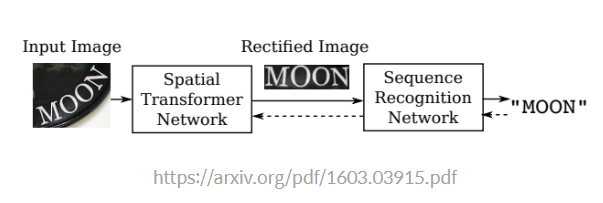

```
💠 Spatial Transformer Network란 인풋 이미지에 크기, 위치, 회전 등의 변환을 가해 추론을 더욱 용이하게 하는 transform matrix를 찾아 매핑해 주는 네트워크를 말합니다. 이해를 돕기 위해 아래 링크를 참고하세요.

https://3months.tistory.com/197
```

## 11-5 Text recognition + Attention

Attection과 Transformer가 딥러닝 분야에 큰 변화를 가져왔고 OCR 분야도 예외는 아니다.

### 1. Attention Sequence prediction

https://arxiv.org/pdf/1603.03915.pdf

https://arxiv.org/pdf/1709.02054.pdf

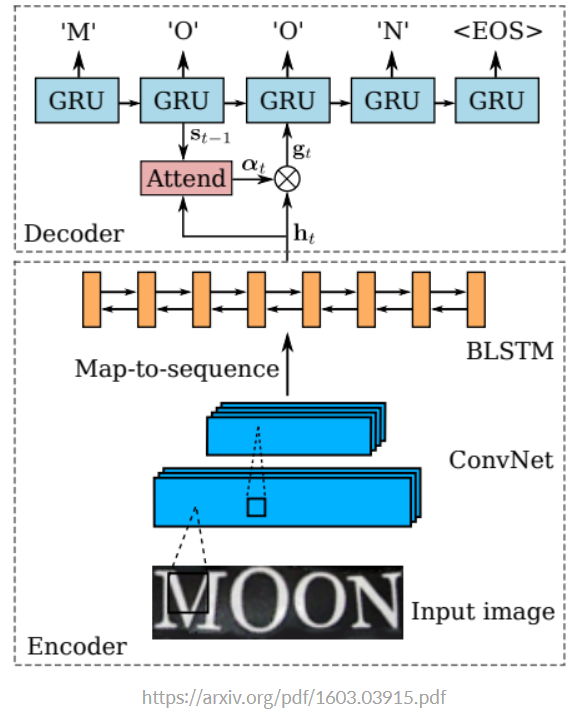

CTC를 활용한 CRNN의 경우, column에 따라서 prediction된 Label의 중복된 것들을 제거해 줌으로써 원하는 형태의 label로 만들어줬었다.

Attention기반의 sequence prediction은 문장의 길이를 고정하고, 입력되는 Feature에 대한 Attention을 기반으로 해당 글자의 Label을 prediction합니다. RNN으로 Character label을 뽑아낸다고 생각하면 되는데, 첫 번째 글자에서 입력 feature에 대한 Attention을 기반으로 label을 추정하고, 추정된 label을 다시 입력으로 사용하여 다음 글자를 추정해내는 방식이다.

이때 20글자를 뽑겠다고 정하게 되면 "YOU"같은 경우에는 3글자를 채우고 빈자리가 문제가 되는데, 이러한 경우를 위해 미리 정해둔 Token을 사용한다. Token에는 처음에 사용되는 "start" token과 끝에 사용되는 "end" token이 있고 필요에 따라서 예외처리나 공백을 위한 token을 만들어서 사용하기도 한다.

https://arxiv.org/pdf/1904.01906.pdf

Attention 기반의 Recognition이 더욱 좋은 성능을 보이고 있는 것을 위 링크에 소개한 네이버 Clova의 논문 'What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis'에서 확인할 수 있다. 

이 논문에서는 CTC와 attention만이 아니라 TPS 등 Recognition에서 쓰이는 다양한 모듈들을 비교 평가를 하고 있다. 

https://www.youtube.com/watch?v=NQeaLc2X8vk&t=4s

위 영상은 네이버 Clova에서 CRAFT와 "What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis"에 대해서 설명해 주는 영상이니 참고하시면 좋다. 

### 2. Transformer와 함께

https://arxiv.org/pdf/1904.01375v1.pdf

https://hulk89.github.io/machine%20learning/2019/05/15/A-Simple-and-Robust-Convolutional-Attention-Network-For-Irregular-Text-Recognition/

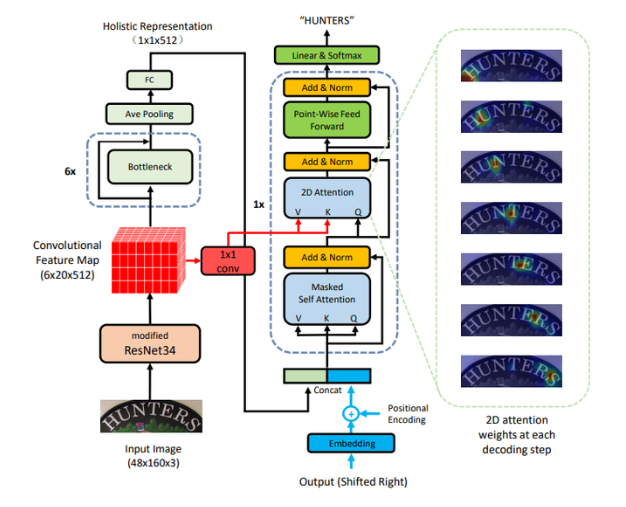


Transformer도 Recognition 모델에 활용되기 시작했다. 다양한 논문에서 시도하고 있지만 `A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition`가 대표적인 논문이다. 

위 논문에서는 Irregular text를 잘 인식하기 위해서 2d space에 대한 attention을 활용하여 문자를 인식하기 위해 Transformer를 활용한다. 

Transformer는 Query, Key, Value라는 개념을 통해 Self-Attention을 입력으로부터 만들어낸다. 이를 통해 입력에서 중요한 Feature에 대해 Weight를 주게 된다.

Attention의 핵심은 Decoder의 현재 포지션에서 중요한 Encoder의 State에 가중치가 높게 매겨진다는 점이다.

위 사지는 Attention이 시각화된 이미지를 눈으로 볼 수 있는데, Decoder의 각 Step에 따라서 입력에 대한 Visual Attention이 시각화된 모습이다.